# Preprocessing for numerical features

In this notebook, we still use numerical features only.

Here we introduce these new aspects:

* an example of preprocessing, namely **scaling numerical variables**;
* using a scikit-learn **pipeline** to chain preprocessing and model training.

## Data preparation

First, let's load the full adult census dataset.

In [1]:
import pandas as pd

adult_census = pd.read_csv("../datasets/adult-census.csv")

We now drop the target from the data we use to train our predictive model.

In [2]:
target_name = "class"
target = adult_census[target_name]
data = adult_census.drop(columns=target_name)

Then, we select only the numerical columns, as seen in the previous notebook.

In [3]:
numerical_columns = ["age", "capital-gain", "capital-loss", "hours-per-week"]

data_numeric = data[numerical_columns]

Finally, we can divide our dataset into a train and test sets.

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data_numeric, target, random_state=42
)

## Model fitting with preprocessing

A range of preprocessing algorithms in scikit-learn allow us to transform the
input data before training a model. In our case, we will standardize the data
and then train a new logistic regression model on that new version of the
dataset.

Let's start by printing some statistics about the training data.

In [5]:
data_train.describe()

,age,capital-gain,capital-loss,hours-per-week
count,36631.000000,36631.000000,36631.000000,36631.000000
mean,38.642352,1087.077721,89.665311,40.431247
std,13.725748,7522.692939,407.110175,12.423952
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,48.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


We see that the dataset's features span across different ranges. Some
algorithms make some assumptions regarding the feature distributions and
normalizing features is usually helpful to address such assumptions.

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p>Here are some reasons for scaling features:</p>
<ul class="last simple">
<li>Models that rely on the distance between a pair of samples, for instance
k-nearest neighbors, should be trained on normalized features to make each
feature contribute approximately equally to the distance computations.</li>
<li>Many models such as logistic regression use a numerical solver (based on
gradient descent) to find their optimal parameters. This solver converges
faster when the features are scaled, as it requires less steps (called
<strong>iterations</strong>) to reach the optimal solution.</li>
</ul>
</div>

Whether or not a machine learning model requires scaling the features depends
on the model family. Linear models such as logistic regression generally
benefit from scaling the features while other models such as decision trees do
not need such preprocessing (but would not suffer from it).

We show how to apply such normalization using a scikit-learn transformer
called `StandardScaler`. This transformer shifts and scales each feature
individually so that they all have a 0-mean and a unit standard deviation.
We recall that transformers are estimators that have a `transform` method.

We now investigate different steps used in scikit-learn to achieve such a
transformation of the data.

First, one needs to call the method `fit` in order to learn the scaling from
the data.

In [6]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(data_train)

,copy,True
,with_mean,True
,with_std,True


The `fit` method for transformers is similar to the `fit` method for
predictors. The main difference is that the former has a single argument (the
data matrix), whereas the latter has two arguments (the data matrix and the
target).

![Transformer fit diagram](../figures/api_diagram-transformer.fit.svg)

In this case, the algorithm needs to compute the mean and standard deviation
for each feature and store them into some NumPy arrays. Here, these statistics
are the model states.

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">The fact that the model states of this scaler are arrays of means and standard
deviations is specific to the <tt class="docutils literal">StandardScaler</tt>. Other scikit-learn
transformers may compute different statistics and store them as model states,
in a similar fashion.</p>
</div>

We can inspect the computed means and standard deviations.

In [7]:
scaler.mean_

array([  38.64235211, 1087.07772106,   89.6653108 ,   40.43124676])

In [8]:
scaler.scale_

array([  13.72556083, 7522.59025606,  407.10461772,   12.42378265])

<div class="admonition note alert alert-info">
<p class="first admonition-title" style="font-weight: bold;">Note</p>
<p class="last">scikit-learn convention: if an attribute is learned from the data, its name
ends with an underscore (i.e. <tt class="docutils literal">_</tt>), as in <tt class="docutils literal">mean_</tt> and <tt class="docutils literal">scale_</tt> for the
<tt class="docutils literal">StandardScaler</tt>.</p>
</div>

Scaling the data is applied to each feature individually (i.e. each column in
the data matrix). For each feature, we subtract its mean and divide by its
standard deviation.

Once we have called the `fit` method, we can perform data transformation by
calling the method `transform`.

In [9]:
data_train_scaled = scaler.transform(data_train)
data_train_scaled

array([[ 0.17177061, -0.14450843,  5.71188483, -2.28845333],
       [ 0.02605707, -0.14450843, -0.22025127, -0.27618374],
       [-0.33822677, -0.14450843, -0.22025127,  0.77019645],
       ...,
       [-0.77536738, -0.14450843, -0.22025127, -0.03471139],
       [ 0.53605445, -0.14450843, -0.22025127, -0.03471139],
       [ 1.48319243, -0.14450843, -0.22025127, -2.69090725]])

Let's illustrate the internal mechanism of the `transform` method and put it
to perspective with what we already saw with predictors.

![Transformer transform
diagram](../figures/api_diagram-transformer.transform.svg)

The `transform` method for transformers is similar to the `predict` method for
predictors. It uses a predefined function, called a **transformation
function**, and uses the model states and the input data. However, instead of
outputting predictions, the job of the `transform` method is to output a
transformed version of the input data.

Finally, the method `fit_transform` is a shorthand method to call successively
`fit` and then `transform`.

![Transformer fit_transform diagram](../figures/api_diagram-transformer.fit_transform.svg)

In scikit-learn jargon, a **transformer** is defined as an estimator (an
object with a `fit` method) supporting `transform` or `fit_transform`.

In [10]:
data_train_scaled = scaler.fit_transform(data_train)
data_train_scaled

array([[ 0.17177061, -0.14450843,  5.71188483, -2.28845333],
       [ 0.02605707, -0.14450843, -0.22025127, -0.27618374],
       [-0.33822677, -0.14450843, -0.22025127,  0.77019645],
       ...,
       [-0.77536738, -0.14450843, -0.22025127, -0.03471139],
       [ 0.53605445, -0.14450843, -0.22025127, -0.03471139],
       [ 1.48319243, -0.14450843, -0.22025127, -2.69090725]])

By default, all scikit-learn transformers output NumPy arrays. Since
scikit-learn 1.2, it is possible to set the output to be a pandas dataframe,
which makes data exploration easier as it preserves the column names. The
method `set_output` controls this behaviour. Please refer to this [example
from the scikit-learn
documentation](https://scikit-learn.org/stable/auto_examples/miscellaneous/plot_set_output.html)
for more options to configure the output of transformers.

In [11]:
scaler = StandardScaler().set_output(transform="pandas")
data_train_scaled = scaler.fit_transform(data_train)
data_train_scaled.describe()

,age,capital-gain,capital-loss,hours-per-week
count,3.663100e+04,3.663100e+04,3.663100e+04,3.663100e+04
mean,-2.273364e-16,3.530310e-17,3.840667e-17,1.844684e-16
std,1.000014e+00,1.000014e+00,1.000014e+00,1.000014e+00
min,-1.576792e+00,-1.445084e-01,-2.202513e-01,-3.173852e+00
25%,-7.753674e-01,-1.445084e-01,-2.202513e-01,-3.471139e-02
50%,-1.196565e-01,-1.445084e-01,-2.202513e-01,-3.471139e-02
75%,6.817680e-01,-1.445084e-01,-2.202513e-01,3.677425e-01
max,3.741752e+00,1.314865e+01,1.047970e+01,4.714245e+00


Notice that the mean of all the columns is close to 0 and the standard
deviation in all cases is close to 1. We can also visualize the effect of
`StandardScaler` using a jointplot to show both the histograms of the
distributions and a scatterplot of any pair of numerical features at the same
time. We can observe that `StandardScaler` does not change the structure of
the data itself but the axes get shifted and scaled.

/home/karansinghthakor/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


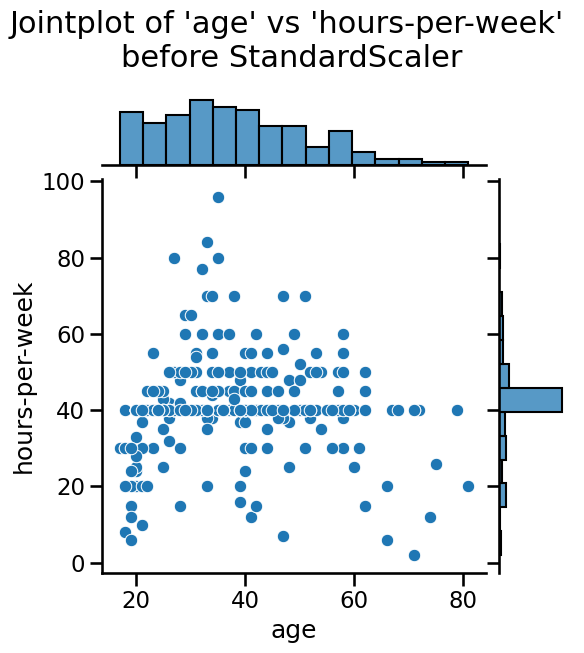

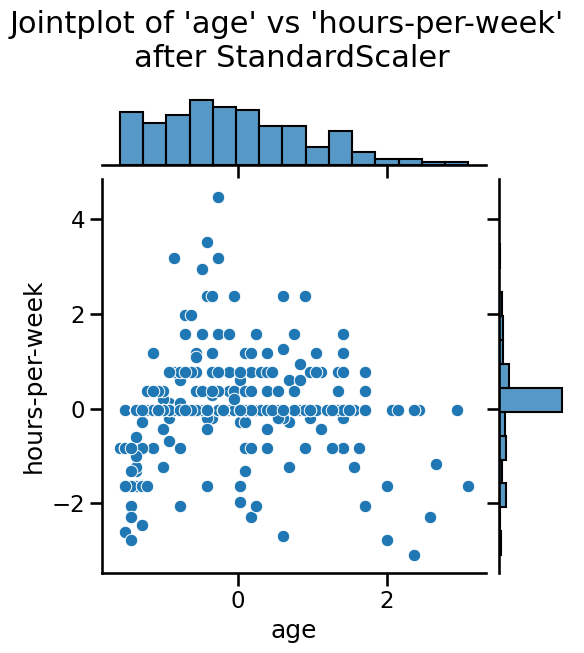

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# number of points to visualize to have a clearer plot
num_points_to_plot = 300

sns.jointplot(
    data=data_train[:num_points_to_plot],
    x="age",
    y="hours-per-week",
    marginal_kws=dict(bins=15),
)
plt.suptitle(
    "Jointplot of 'age' vs 'hours-per-week' \nbefore StandardScaler", y=1.1
)

sns.jointplot(
    data=data_train_scaled[:num_points_to_plot],
    x="age",
    y="hours-per-week",
    marginal_kws=dict(bins=15),
)
_ = plt.suptitle(
    "Jointplot of 'age' vs 'hours-per-week' \nafter StandardScaler", y=1.1
)

We can easily combine sequential operations with a scikit-learn `Pipeline`,
which chains together operations and is used as any other classifier or
regressor. The helper function `make_pipeline` creates a `Pipeline`: it
takes as arguments the successive transformations to perform, followed by the
classifier or regressor model.

In [13]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(), LogisticRegression())
model

,steps,"[('standardscaler', ...), ('logisticregression', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


The `make_pipeline` function did not require us to give a name to each step.
Indeed, it was automatically assigned based on the name of the classes
provided; a `StandardScaler` step is named `"standardscaler"` in the resulting
pipeline. We can check the name of each steps of our model:

In [14]:
model.named_steps

{'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression()}

This predictive pipeline exposes the same methods as the final predictor:
`fit` and `predict` (and additionally `predict_proba`, `decision_function`, or
`score`).

In [15]:
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

We can represent the internal mechanism of a pipeline when calling `fit` by
the following diagram:

![pipeline fit diagram](../figures/api_diagram-pipeline.fit.svg)

When calling `model.fit`, the method `fit_transform` from each underlying
transformer (here a single transformer) in the pipeline is called to:

- learn their internal model states
- transform the training data. Finally, the preprocessed data are provided to
  train the predictor.

To predict the targets given a test set, one uses the `predict` method.

In [16]:
predicted_target = model.predict(data_test)
predicted_target[:5]

array([' <=50K', ' <=50K', ' >50K', ' <=50K', ' <=50K'], dtype=object)

Let's show the underlying mechanism:

![pipeline predict diagram](../figures/api_diagram-pipeline.predict.svg)

The method `transform` of each transformer (here a single transformer) is
called to preprocess the data. Note that there is no need to call the `fit`
method for these transformers because we are using the internal model states
computed when calling `model.fit`. The preprocessed data is then provided to
the predictor that outputs the predicted target by calling its method
`predict`.

As a shorthand, we can check the score of the full predictive pipeline calling
the method `model.score`. Thus, let's check the computational and
generalization performance of such a predictive pipeline.

In [17]:
model_name = model.__class__.__name__
score = model.score(data_test, target_test)
print(
    f"The accuracy using a {model_name} is {score:.3f} "
    f"with a fitting time of {elapsed_time:.3f} seconds "
    f"in {model[-1].n_iter_[0]} iterations"
)

The accuracy using a Pipeline is 0.807 with a fitting time of 0.206 seconds in 9 iterations


We could compare this predictive model with the predictive model used in the
previous notebook which did not scale features.

In [18]:
model = LogisticRegression()
start = time.time()
model.fit(data_train, target_train)
elapsed_time = time.time() - start

In [19]:
model_name = model.__class__.__name__
score = model.score(data_test, target_test)
print(
    f"The accuracy using a {model_name} is {score:.3f} "
    f"with a fitting time of {elapsed_time:.3f} seconds "
    f"in {model.n_iter_[0]} iterations"
)

The accuracy using a LogisticRegression is 0.807 with a fitting time of 2.367 seconds in 60 iterations


We see that scaling the data before training the logistic regression was
beneficial in terms of computational performance. Indeed, the number of
iterations decreased as well as the training time. The generalization
performance did not change since both models converged.

<div class="admonition warning alert alert-danger">
<p class="first admonition-title" style="font-weight: bold;">Warning</p>
<p class="last">Working with non-scaled data will potentially force the algorithm to iterate
more as we showed in the example above. There is also the catastrophic
scenario where the number of required iterations is larger than the maximum
number of iterations allowed by the predictor (controlled by the <tt class="docutils literal">max_iter</tt>)
parameter. Therefore, before increasing <tt class="docutils literal">max_iter</tt>, make sure that the data
are well scaled.</p>
</div>

In this notebook we:

* saw the importance of **scaling numerical variables**;
* used a **pipeline** to chain scaling and logistic regression training.